# Fake News Detection Using Text Classification Techniques

# Loading Librarries

In [1]:
# Uninstall and reinstall nltk to ensure a clean and up-to-date installation
!pip uninstall -y nltk
!pip install nltk

Found existing installation: nltk 3.9.1
Uninstalling nltk-3.9.1:
  Successfully uninstalled nltk-3.9.1
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)


In [2]:
#Loading Libraries
import re
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
import joblib
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1.DATA PREPARATION

# Loading the Data Set

In [3]:
# Reading csv file and putting information in dataframe
df = pd.read_csv("/content/train.csv", engine='python', on_bad_lines='skip')
pd.set_option('display.max_colwidth', None) # Setting this so we can see the full content of cells
pd.set_option('display.max_columns', None) # to make sure we can see all the columns in output window

In [4]:
# Cleaning from the News dataset
def cleaner(news):
    soup = BeautifulSoup(news, 'lxml') # removing HTML entities such as ‘&amp’,’&quot’,'&gt'; lxml is the html parser and shoulp be installed using 'pip install lxml'
    souped = soup.get_text()
    re1 = re.sub(r"(@|http://|https://|www|\\x)\S*", " ", souped) # substituting @mentions, urls, etc with whitespace
    re2 = re.sub("[^A-Za-z]+"," ", re1) # substituting any non-alphabetic character that repeats one or more times with whitespace

    """
    For more info on regular expressions visit -
    https://docs.python.org/3/howto/regex.html
    """

    tokens = nltk.word_tokenize(re2)#Tokenizes the cleaned sentence into words.
    lower_case = [t.lower() for t in tokens]#Converts all tokens to lowercase.

    stop_words = set(stopwords.words('english'))#Filters out common English stopwords (e.g., "the", "is", "in", etc.) using NLTK's stopword list.
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))

    wordnet_lemmatizer = WordNetLemmatizer()#- Lemmatize each word as a verb using WordNetLemmatizer, so we reduce different forms of a word to a base meaning (e.g., "running" → "run").
    lemmas = [wordnet_lemmatizer.lemmatize(t,'v') for t in filtered_result]
    return lemmas

df['cleaned_news'] = df.statement.apply(cleaner)#apply cleaner to'statement'column
df = df[df['cleaned_news'].map(len) > 0] # removing rows with cleaned news of length 0
print("Printing top 5 rows of dataframe showing original and cleaned news....")
print(df[['statement','cleaned_news']].head())

df.drop(['id', 'date', 'speaker','speaker_description','state_info','subject','true_counts',
'mostly_true_counts','context','justification','false_counts','half_true_counts','half_true_counts',
'mostly_false_counts','pants_on_fire_counts'], axis=1, inplace=True)#Drops the columns that are not needed for modeling.

#Before implementing models we must make the labels binary for better model accuracy
df['binary_label'] = df['label'].apply(lambda x: 1 if x in [0, 1, 2] else 0)
df.drop(['label'], axis=1, inplace=True) #dropping the label column as it is not needed anymore

# Saving cleaned news to csv
df.to_csv('cleaned_data.csv', index=False)#saves the cleaned news and labels to a CSV file.
df['cleaned_news'] = [" ".join(row) for row in df['cleaned_news'].values] # joining tokens to create strings. TfidfVectorizer does not accept tokens as input
data = df['cleaned_news']

Y = df['binary_label'] # target column is now 'binary_label'
#TF-IDF helps us convert text into numerical values based on how important a word is in a document relative to the corpus.
#This is crucial for enabling machine learning models to analyze patterns in textual data.
tfidf = TfidfVectorizer(min_df=.00163,ngram_range=(1,2))#


#Min_df=.0.00163 means that each ngram (unigram, bigram, & trigram) must be present in at least 30 documents for it to be considered as a token (18370x0.00163=30).
tfidf.fit(data) # Learn vocabulary of entire data
data_tfidf = tfidf.transform(data) # creating tfidf values
pd.DataFrame(pd.Series(tfidf.get_feature_names_out())).to_csv('vocabulary.csv', header=False, index=False)
print("Shape of tfidf matrix: ", data_tfidf.shape)


Printing top 5 rows of dataframe showing original and cleaned news....
                                                                                                                    statement  \
0                                            90 percent of Americans "support universal background checks" for gun purchases.   
1                                                 Last year was one of the deadliest years ever for law enforcement officers.   
2                                                                Bernie Sanders's plan is "to raise your taxes to 90 percent.   
3  Voter ID is supported by an overwhelming majority of NYers, from all across the state, walks of life, & political parties.   
4                                              Says Barack Obama "robbed Medicare (of) $716 billion to pay for ... Obamacare.   

                                                                                    cleaned_news  
0                     [percent, americans, support, uni

/tmp/ipython-input-2893913458.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='binary_label', data=df, palette='Set2')


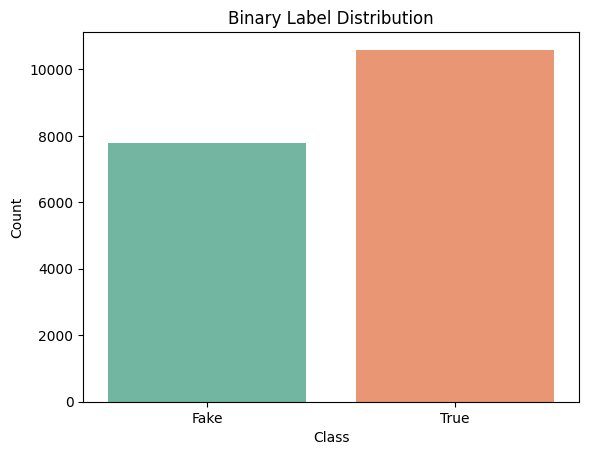

In [5]:
#Checking the proportion of imbalances with ''false'' and ''true''
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='binary_label', data=df, palette='Set2')
plt.xticks([0, 1], ['Fake', 'True'])
plt.title("Binary Label Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [6]:
Y.value_counts()#Numerical check

,count
binary_label,
1,10591
0,7778


##2.MODEL CREATION

# 1.SVC AND Multinominal Naive Bayes

In [7]:
# Initialize models
models = {
    'SVC': LinearSVC(),
    'NBC': MultinomialNB()
}

In [8]:
# Set up cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Perform cross-validation for each model
for name, model in models.items():
    print(f"\n=== {name} Cross-Validation ===")
    scores = []
    iteration = 0

    for train_index, test_index in kf.split(data_tfidf, Y):
        iteration += 1
        print(f"Iteration {iteration}")

        # Define training and test data
        X_train, Y_train = data_tfidf[train_index], Y[train_index]
        X_test, Y_test = data_tfidf[test_index], Y[test_index]

        # Train model
        model.fit(X_train, Y_train)

        # Make predictions
        Y_pred = model.predict(X_test)

        # Calculate accuracy
        score = metrics.accuracy_score(Y_test, Y_pred)
        print(f"Cross-validation accuracy: {score:.4f}")
        scores.append(score)
         # Calculate mean accuracy and standard deviation
    mean_accuracy = np.mean(scores)
    std_accuracy = np.std(scores)

    print(f"Mean cross-validation accuracy: {mean_accuracy:.4f}")
    print(f"Standard deviation: {std_accuracy:.4f}")


=== SVC Cross-Validation ===
Iteration 1
Cross-validation accuracy: 0.6641
Iteration 2
Cross-validation accuracy: 0.6658
Iteration 3
Cross-validation accuracy: 0.6679
Iteration 4
Cross-validation accuracy: 0.6614
Iteration 5
Cross-validation accuracy: 0.6473
Iteration 6
Cross-validation accuracy: 0.6625
Iteration 7
Cross-validation accuracy: 0.6679
Iteration 8
Cross-validation accuracy: 0.6570
Iteration 9
Cross-validation accuracy: 0.6772
Iteration 10
Cross-validation accuracy: 0.6699
Mean cross-validation accuracy: 0.6641
Standard deviation: 0.0076

=== NBC Cross-Validation ===
Iteration 1
Cross-validation accuracy: 0.6794
Iteration 2
Cross-validation accuracy: 0.6717
Iteration 3
Cross-validation accuracy: 0.6837
Iteration 4
Cross-validation accuracy: 0.6723
Iteration 5
Cross-validation accuracy: 0.6576
Iteration 6
Cross-validation accuracy: 0.6543
Iteration 7
Cross-validation accuracy: 0.6750
Iteration 8
Cross-validation accuracy: 0.6576
Iteration 9
Cross-validation accuracy: 0.6886

In [9]:
clf = LinearSVC().fit(data_tfidf, Y)
joblib.dump(clf, 'svc.sav')#saved the model


['svc.sav']

## 2.Random Forest **Classifier**

In [10]:
#1.Train-test split(80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    data_tfidf, Y, test_size=0.2, random_state=42
)

#2.Balancing the labels
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


#3.Define Random Forest model
rf = RandomForestClassifier(random_state=42)

#4.Define parameter grid
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']#I identify that there is a class imblalance,that is why balanced GridSearch is implemented
}

#5.Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='recall'  # #Because we are after True Positives(fake news)
)

#6.Fit model
grid_search.fit(X_train, y_train)

#7.Best model
best_model = grid_search.best_estimator_
print("Best Parameters:\n", grid_search.best_params_)

#8.Predict and evaluation of test
y_pred = best_model.predict(X_test)

#9.Evaluation metrics
#Accuracy**: Measures overall correctness.
#Precision**: The ability to not label a real news article as fake.
#Recall**: The ability to find all fake news articles.
#F1-Score**: Harmonic mean of precision and recall.
#onfusion Matrix**: Visualizes true/false positives and negatives.
#ROC Curve & AUC**: Highlights model's ability to distinguish between classes.
print('Random Forest Classifier Metrics')
Accuracy=metrics.accuracy_score(y_test, y_pred) # calculating accuracy
print("Accuracy: ", Accuracy)
con_matrix = metrics.confusion_matrix(y_test, y_pred) # confusion matrix
print (con_matrix)
recall = metrics.recall_score(y_test, y_pred) # recall metric
print (f'Recall:',recall)
precision = metrics.precision_score(y_test, y_pred) #precision metric
print (f'Precision',precision)
f1 = metrics.f1_score(y_test, y_pred) #f1 metric
print (f'F1:',f1)

#10.Saving the model
joblib.dump(best_model,'random_forest.sav')



Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters:
 {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Classifier Metrics
Accuracy:  0.6589548176374523
[[1006  571]
 [ 682 1415]]
Recall: 0.6747734859322843
Precision 0.7124874118831823
F1: 0.6931178055351457


['random_forest.sav']

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.64      0.62      1577
           1       0.71      0.67      0.69      2097

    accuracy                           0.66      3674
   macro avg       0.65      0.66      0.65      3674
weighted avg       0.66      0.66      0.66      3674



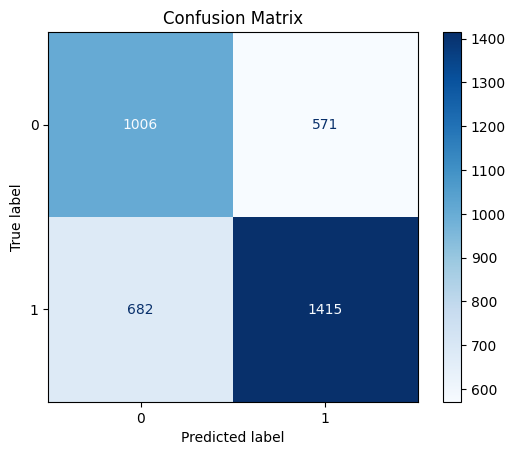

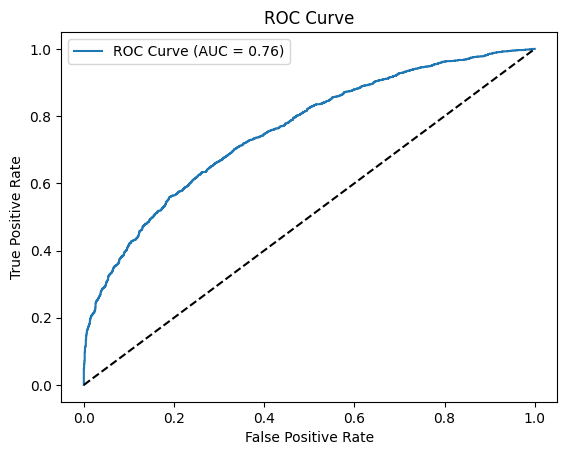

In [11]:
#11.Classification report&Confusion matrixROC Curve
# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 3.Logistic Regression

In [12]:
#1.Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    data_tfidf, Y, test_size=0.2, random_state=42
)

#2.Balancing the labels
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

#3.Define Logistic Regression model
log_reg = LogisticRegression(random_state=42, solver='liblinear')

#4Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],        # Regularization strength
    'penalty': ['l1', 'l2'],        # L1 or L2 regularization
    'class_weight': ['balanced']
}

#5.Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='recall'  #Because we are after True Positives(fake news)
)

#6.Fit model
grid_search.fit(X_train, y_train)

#7.Best model
best_model = grid_search.best_estimator_
print("Best Parameters:\n", grid_search.best_params_)

#8.Predict and evaluate
y_pred = best_model.predict(X_test)


#9.Evaluation metrics
#Accuracy**: Measures overall correctness.
#Precision**: The ability to not label a real news article as fake.
#Recall**: The ability to find all fake news articles.
#F1-Score**: Harmonic mean of precision and recall.
#onfusion Matrix**: Visualizes true/false positives and negatives.
#ROC Curve & AUC**: Highlights model's ability to distinguish between classes.
print('Logistic Regression Metrics')
Accuracy=metrics.accuracy_score(y_test, y_pred) # calculating accuracy
print("Accuracy: ", Accuracy)
con_matrix = metrics.confusion_matrix(y_test, y_pred) # confusion matrix
print (con_matrix)
recall = metrics.recall_score(y_test, y_pred) # recall metric
print (f'Recall:',recall)
precision = metrics.precision_score(y_test, y_pred) #precision metric
print (f'Precision',precision)
f1 = metrics.f1_score(y_test, y_pred) #f1 metric
print (f'F1:',f1)

#10.Saving the model
joblib.dump(best_model, 'logistic_regression.sav')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters:
 {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2'}
Logistic Regression Metrics
Accuracy:  0.6420794774088188
[[1021  556]
 [ 759 1338]]
Recall: 0.6380543633762518
Precision 0.706441393875396
F1: 0.6705086444500126


['logistic_regression.sav']

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.65      0.61      1577
           1       0.71      0.64      0.67      2097

    accuracy                           0.64      3674
   macro avg       0.64      0.64      0.64      3674
weighted avg       0.65      0.64      0.64      3674



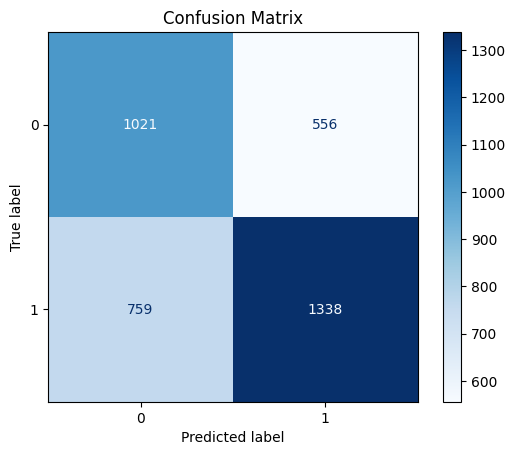

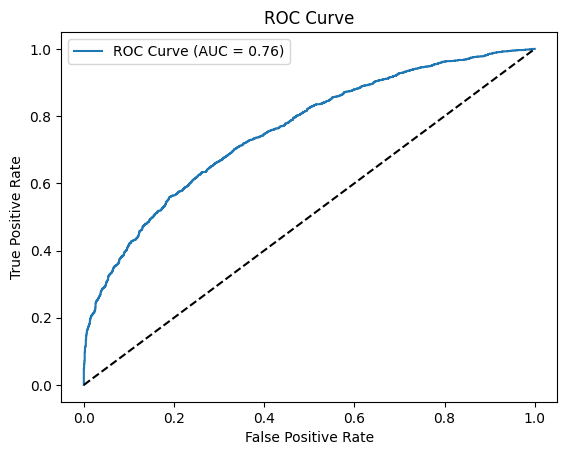

In [13]:
#11.Classification report&Confusion matrix&ROC Curve
# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [14]:
#REAL WORLD USE&DEPLOYMENT
import re, nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Importing saved model and its vocabulary
loaded_model = joblib.load('logistic_regression.sav')
vocabulary = pd.read_csv('/content/vocabulary.csv', header=None)

# Representing model vocabulary as a dictionary, where keys are terms and values are indices in the feature matrix
vocabulary_dict = {}
for i, word in enumerate(vocabulary[0]):
      vocabulary_dict[word] = i

# Reading new data as dataframe
df = pd.read_csv("real_life_test.csv")
pd.set_option('display.max_colwidth', None) # Setting this so we can see the full content of cells
pd.set_option('display.max_columns', None) # to make sure we can see all the columns in output window

# Cleaning News
def cleaner(news):
    soup = BeautifulSoup(news, 'lxml') # removing HTML entities such as ‘&amp’,’&quot’,'&gt'; lxml is the html parser and shoulp be installed using 'pip install lxml'
    souped = soup.get_text()
    re1 = re.sub(r"(@|http://|https://|www|\\x)\S*", " ", souped) # substituting @mentions, urls, etc with whitespace
    re2 = re.sub("[^A-Za-z]+"," ", re1) # substituting any non-alphabetic character that repeats one or more times with whitespace

    """
    For more info on regular expressions visit -
    https://docs.python.org/3/howto/regex.html
    """

    tokens = nltk.word_tokenize(re2)#Tokenize and Normalize contents
    lower_case = [t.lower() for t in tokens]# turen them ,n to lowercase

    stop_words = set(stopwords.words('english'))#Filters out common English stopwords (e.g., "the", "is", "in", etc.) using NLTK's stopword list.
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))

    wordnet_lemmatizer = WordNetLemmatizer()#Converts each word to its base form (e.g., “running” → “run”).
    lemmas = [wordnet_lemmatizer.lemmatize(t,'v') for t in filtered_result]
    return lemmas

df['cleaned_news'] = df.statement.apply(cleaner)#apply cleaner to'statement'column
df = df[df['cleaned_news'].map(len) > 0] # removing rows with cleaned tweets of length 0
print("Printing top 5 rows of dataframe showing original and cleaned news....")
print(df[['statement','cleaned_news']].head())
df['cleaned_news'] = [" ".join(row) for row in df['cleaned_news'].values] # joining tokens to create strings. TfidfVectorizer does not accept tokens as input
data = df['cleaned_news']

df.drop(['id', 'date', 'speaker','speaker_description','state_info','subject','true_counts','mostly_true_counts','context','justification','false_counts','half_true_counts','half_true_counts','mostly_false_counts','pants_on_fire_counts'], axis=1, inplace=True)
df['binary_label'] = df['label'].apply(lambda x: 1 if x in [0, 1, 2] else 0)

# Passing model vocabulary to TfidfVectorizer
tfidf = TfidfVectorizer(vocabulary = vocabulary_dict,lowercase=False)

# Representing new data as TF-IDF matrix
data_tfidf = tfidf.fit_transform(data)

# Making predictions on new data with Logistics Regression
y_pred = loaded_model.predict(data_tfidf)

# Saving predictions to csv
df['predicted_news'] = y_pred.reshape(-1,1)
df.to_csv('predicted_news.csv', index=False)




[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Printing top 5 rows of dataframe showing original and cleaned news....
                                                                                                                                     statement  \
0  Three doctors from the same hospital 'die suddenly' in the same week," after the hospital mandated a fourth COVID-19 vaccine for employees.   
1                                                                                                                Say Joe Biden is a pedophile.   
2                                                 A photo shows President Joe Biden and Ukrainian President Volodymyr Zelenskyy holding hands.   
3                                                                       It will cost $50,000 per enrollee in Obamacare over the next 10 years.   
4            The Federal Register - which houses all Washington regulations - is 34,000 pages in length and weighs in at more than 340 pounds.   

                                                    

In [15]:
df.head(100)

,label,statement,cleaned_news,binary_label,predicted_news
0,1,"Three doctors from the same hospital 'die suddenly' in the same week,"" after the hospital mandated a fourth COVID-19 vaccine for employees.",three doctor hospital die suddenly week hospital mandate fourth covid vaccine employees,1,1
1,0,Say Joe Biden is a pedophile.,say joe biden pedophile,1,1
2,1,A photo shows President Joe Biden and Ukrainian President Volodymyr Zelenskyy holding hands.,photo show president joe biden ukrainian president volodymyr zelenskyy hold hand,1,1
3,1,"It will cost $50,000 per enrollee in Obamacare over the next 10 years.",cost per enrollee obamacare next years,1,0
4,3,"The Federal Register - which houses all Washington regulations - is 34,000 pages in length and weighs in at more than 340 pounds.",federal register house washington regulations page length weigh pound,0,1
...,...,...,...,...,...
95,0,"Says a photo shows Beto O'Rourke ""in college drunk and pissing his pants.",say photo show beto rourke college drink piss pant,1,1
96,1,Half of children struck by cars near schools are hit by parents driving children to school.,half children strike cars near school hit parent drive children school,1,0
97,0,Violent crime rates increased in all but two Wisconsin cities between 2008 and 2017.,violent crime rat increase two wisconsin cities,1,0
98,1,"Says photo shows ""one of Tesla's lithium supply mines where entire mountains are eliminated.",say photo show one tesla lithium supply mine entire mountains eliminate,1,1


# 4.Visualisation of Word Cloud

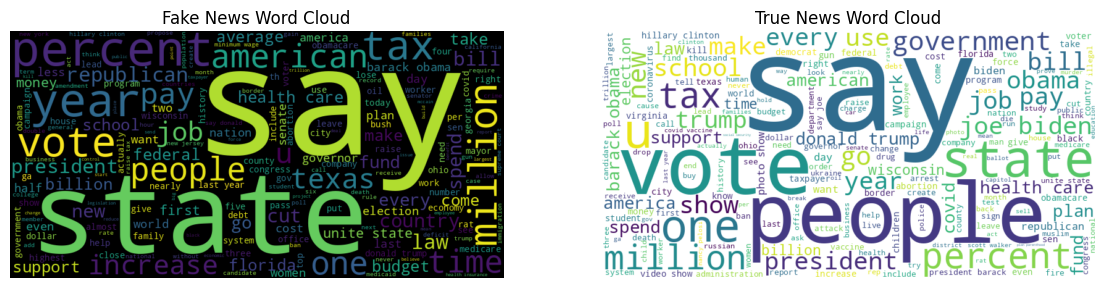

In [16]:
from wordcloud import WordCloud

fake_text = " ".join(df[df['binary_label'] == 0]['cleaned_news'])
true_text = " ".join(df[df['binary_label'] == 1]['cleaned_news'])

wordcloud_fake = WordCloud(width=800, height=400, background_color='black').generate(fake_text)
wordcloud_true = WordCloud(width=800, height=400, background_color='white').generate(true_text)

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Fake News Word Cloud")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis('off')
plt.title("True News Word Cloud")
plt.show()